# **Projet NLP: Classification IA and Human Texts**

<ins>Group :</ins>
- Thomas Sinapi
- Pierre Derathe
- Manitas Bahri

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
import numpy as np
import optuna
import pandas as pd
import torch

from collections import Counter
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from wordcloud import WordCloud

In [2]:
df = pd.read_csv("training.csv")
X, y = df["text"], df["generated"].astype("int")
df.shape

(4000, 2)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

X_train.shape, X_test.shape, X_val.shape

((2800,), (600,), (600,))

## 0. **<ins> Utils functions </ins>**

In [4]:
# nltk.download("stopwords")

In [5]:
def get_vector_w2v(text, model):
    """
    Get the vector representation of a text using Word2Vec model

    Args:
        text: list of words
        model: Word2Vec model

    Returns:
        vector: vector representation of the text
    """
    vector = [0] * model.vector_size
    count = 0
    
    for word in text:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    
    if count != 0:
        vector = [x / count for x in vector]
    
    return vector

In [6]:
def remove_stopwords(tokens_list):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = np.empty_like(tokens_list)
    
    for i, tokens in enumerate(tokens_list):
        filtered_tokens[i] = [word for word in tokens if word not in stop_words]
    
    return pd.Series(filtered_tokens)

## 1. **<ins>Preprocessing</ins>**

### 1.1 **Simple Preprocessing**

In [7]:
tokenizer = RegexpTokenizer(r'\w+')

# Tokenize the X_train
X_train_tok = X_train.map(lambda x: tokenizer.tokenize(x.lower()))
X_train_tok = remove_stopwords(X_train_tok)

# Tokenize the X_test
X_test_tok = X_test.map(lambda x: tokenizer.tokenize(x.lower()))
X_test_tok = remove_stopwords(X_test_tok)

# Tokenize the X_val
X_val_tok = X_val.map(lambda x: tokenizer.tokenize(x.lower()))
X_val_tok = remove_stopwords(X_val_tok)

In [8]:
# Clean data
X_train_clean = X_train_tok.str.join(" ")
X_test_clean = X_test_tok.str.join(" ")
X_val_clean = X_val_tok.str.join(" ")

### 1.2 **TF-IDF**

In [9]:
tfidf = TfidfVectorizer()

# Apply the vectorizer to data
X_train_tfidf = tfidf.fit_transform(X_train_clean)
X_test_tfidf = tfidf.transform(X_test_clean)
X_val_tfidf = tfidf.transform(X_val_clean)

mms = MinMaxScaler()

# Rescale the data to 0-1 (for multinomial nb model)
X_train_tfidf = mms.fit_transform(X_train_tfidf.toarray())
X_test_tfidf = mms.transform(X_test_tfidf.toarray())
X_val_tfidf = mms.transform(X_val_tfidf.toarray())

print("Number of words in vocabulary:", X_train_tfidf.shape[1])

Number of words in vocabulary: 18820


In [10]:
# Print features used in the TF-IDF vectorizer
pprint(tfidf.get_feature_names_out()[1000:1050])

array(['albeit', 'alcohol', 'alcoholic', 'aledged', 'alenhon', 'alergic',
       'alert', 'alertness', 'alerts', 'alex', 'alexa', 'alexander',
       'alfred', 'algorethanks', 'algorithm', 'algorithms', 'alien',
       'alienaite', 'alienate', 'alienated', 'alienating', 'alienation',
       'aliens', 'align', 'aligned', 'alignment', 'aligns', 'alihough',
       'alike', 'alio', 'aliso', 'alittle', 'alive', 'allaround',
       'allays', 'alleged', 'allegedly', 'allen', 'allergic', 'allergies',
       'alleviate', 'alleviated', 'alleviates', 'alleviating',
       'alleviation', 'alliance', 'allocate', 'allocated', 'allocates',
       'allocating'], dtype=object)


### 1.3 **Word2Vec**

In [11]:
w2v = Word2Vec(X_train_tok, vector_size=100, window=5, min_count=1, workers=-1)

# Get the vector representation of word2vec
X_train_w2v = X_train_tok.map(lambda x: get_vector_w2v(x, w2v))
X_test_w2v = X_test_tok.map(lambda x: get_vector_w2v(x, w2v))
X_val_w2v = X_val_tok.map(lambda x: get_vector_w2v(x, w2v))

# Rescale the data to 0-1 (for multinomial nb model)
X_train_w2v = mms.fit_transform(X_train_w2v.values.tolist())
X_test_w2v = mms.transform(X_test_w2v.values.tolist())
X_val_w2v = mms.transform(X_val_w2v.values.tolist())

## 2. **<ins>Data Visualization</ins>**

In [12]:
print("Human Text")
pprint(X[y == 0].iloc[0])

Human Text
('Cars. Cars have been around since they became famous in the 1900s, when '
 'Henry Ford created and built the first ModelT. Cars have played a major role '
 'in our every day lives since then. But now, people are starting to question '
 'if limiting car usage would be a good thing. To me, limiting the use of cars '
 'might be a good thing to do.\n'
 '\n'
 'In like matter of this, article, "In German Suburb, Life Goes On Without '
 'Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of '
 'suburbs, where middle class families from either Shanghai or Chicago tend to '
 'make their homes. Experts say how this is a huge impediment to current '
 'efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are '
 'responsible for 12 percent of greenhouse gas emissions in Europe...and up to '
 '50 percent in some carintensive areas in the United States. Cars are the '
 'main reason for the greenhouse gas emissions because of a lot of people '
 'dri

In [13]:
print("AI Text")
pprint(X[y == 1].iloc[0])

AI Text
('This essay will analyze, discuss and prove one reason in favor of keeping '
 'the Electoral College in the United States for its presidential elections. '
 'One of the reasons to keep the electoral college is that it is better for '
 'smaller, more rural states to have more influence as opposed to larger '
 'metropolitan areas that have large populations. The electors from these '
 'states are granted two votes each. Those from larger, more populated areas '
 'are granted just one vote each. Smaller states tend to hold significant '
 'power because their two votes for president and vice president add up more '
 'than the votes of larger states that have many electors. This is because of '
 'the split of the electoral votes. Some argue that electors are not bound to '
 'vote for the candidate who won the most votes nationally. They do not have '
 "to vote for their own state's nominee unless their state has a winner take "
 'all system. However, there are states that have adop

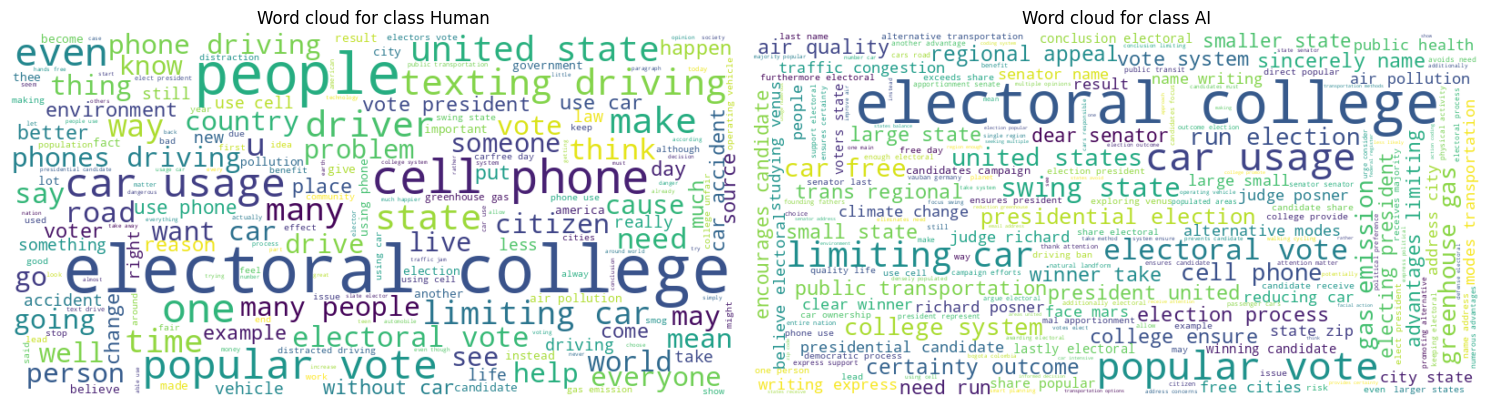

In [15]:
class_0_text = " ".join(X_train_clean[y_train == 0])
class_1_text = " ".join(X_train_clean[y_train == 1])

plt.figure(figsize=(15, 7))

# Word cloud for the class Human
plt.subplot(1, 2, 1)
wordcloud_0 = WordCloud(width=800, height=400, background_color="white").generate(class_0_text)
plt.imshow(wordcloud_0, interpolation="bilinear")
plt.title("Word cloud for class Human")
plt.axis("off")

# Word cloud for the class AI
plt.subplot(1, 2, 2)
wordcloud_1 = WordCloud(width=800, height=400, background_color="white").generate(class_1_text)
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.title("Word cloud for class AI")
plt.axis("off")

plt.tight_layout()
plt.show()


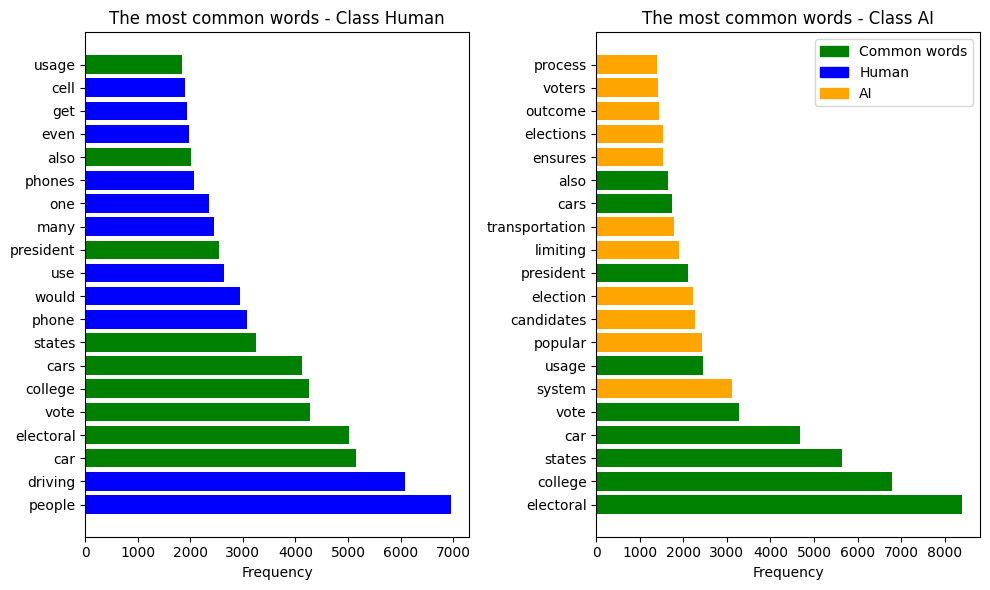

In [16]:
class_0_tokens = " ".join(X_train_clean[y_train == 0]).split()
class_1_tokens = " ".join(X_train_clean[y_train == 1]).split()

top_n = 20
class_0_word_freq = Counter(class_0_tokens).most_common(top_n)
class_1_word_freq = Counter(class_1_tokens).most_common(top_n)

# Get the common words between the two classes
common_words = set([word[0] for word in class_0_word_freq]).intersection([word[0] for word in class_1_word_freq])

# Plot the most common words
plt.figure(figsize=(10, 6))

# Human class
plt.subplot(1, 2, 1)

for i, word in enumerate([freq[0] for freq in class_0_word_freq]):
    color = "green" if word in common_words else "blue"
    plt.barh(i, class_0_word_freq[i][1], color=color)

plt.yticks(range(top_n), [freq[0] for freq in class_0_word_freq])
plt.xlabel("Frequency")
plt.title("The most common words - Class Human")

# AI class
plt.subplot(1, 2, 2)
for i, word in enumerate([freq[0] for freq in class_1_word_freq]):
    color = "green" if word in common_words else "orange"
    plt.barh(i, class_1_word_freq[i][1], color=color)
plt.yticks(range(top_n), [freq[0] for freq in class_1_word_freq])

plt.xlabel("Frequency")
plt.title("The most common words - Class AI")

# Add legend
l1 = mpatches.Patch(color="green", label="Common words")
l2 = mpatches.Patch(color="blue", label="Human")
l3 = mpatches.Patch(color="orange", label="AI")
plt.legend(handles=[l1, l2, l3], loc="upper right")

plt.tight_layout()
plt.show()


## 3. **<ins>Base Model</ins>**

In [17]:
def objective(trial):
    """
    Objective function for the Optuna optimization

    Args:
        trial: Optuna trial object

    Returns:
        score: accuracy score of the model
    """
    # Random Forest hyperparameters
    trial.suggest_int("n_estimators", 50, 150)
    trial.suggest_int("max_depth", 3, 40)
    trial.suggest_int("min_samples_split", 2, 40)
    trial.suggest_int("min_samples_leaf", 1, 20)
    
    # Define the Random Forest model
    rf = RandomForestClassifier(**trial.params, random_state=0, n_jobs=-1)

    return cross_val_score(rf, X_train_w2v, y_train, cv=5, scoring="accuracy").mean()

In [19]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print(study.best_params, study.best_value)

[I 2024-02-28 22:28:51,375] A new study created in memory with name: no-name-92d5d9d3-3123-4c18-9988-008e6864a11b
[I 2024-02-28 22:28:53,047] Trial 0 finished with value: 0.9367857142857143 and parameters: {'n_estimators': 58, 'max_depth': 14, 'min_samples_split': 33, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9367857142857143.
[I 2024-02-28 22:28:56,203] Trial 1 finished with value: 0.9367857142857143 and parameters: {'n_estimators': 105, 'max_depth': 24, 'min_samples_split': 31, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.9367857142857143.
[I 2024-02-28 22:28:57,756] Trial 2 finished with value: 0.8975 and parameters: {'n_estimators': 65, 'max_depth': 3, 'min_samples_split': 31, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9367857142857143.
[I 2024-02-28 22:29:00,730] Trial 3 finished with value: 0.9421428571428571 and parameters: {'n_estimators': 95, 'max_depth': 39, 'min_samples_split': 30, 'min_samples_leaf': 12}. Best is trial 3 with value: 0.942142

{'n_estimators': 87, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1} 0.9550000000000001


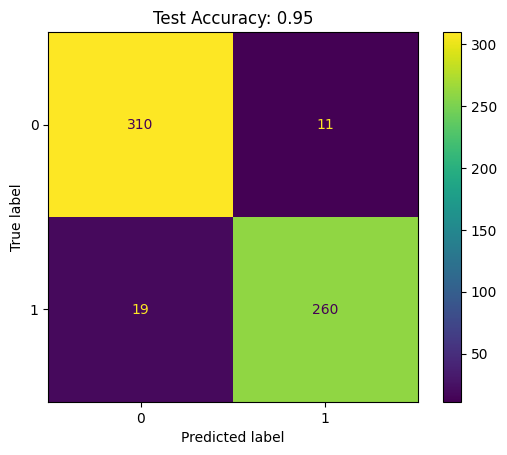

In [20]:
# Train the Random Forest model
rf = RandomForestClassifier(**study.best_params, random_state=0, n_jobs=-1)

rf.fit(X_train_w2v, y_train)

# Predict the test set
y_test_pred = rf.predict(X_test_w2v)

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title(f"(W2V) RF - Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
plt.show()

## 3. **<ins>Comparison of different models</ins>**

Comparative studies of Random Forest and Multinomial NB models using TF-IDF and Word2Vec data.

### 3.1 **Random Forest (TF-IDF)**

In [18]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
y_cv = cross_val_predict(rf, X_train_tfidf, y_train, cv=5)

rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_test_tfidf)

print(f"(TF-IDF) RF - Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(TF-IDF) RF - Cross Validation Accuracy: 0.985


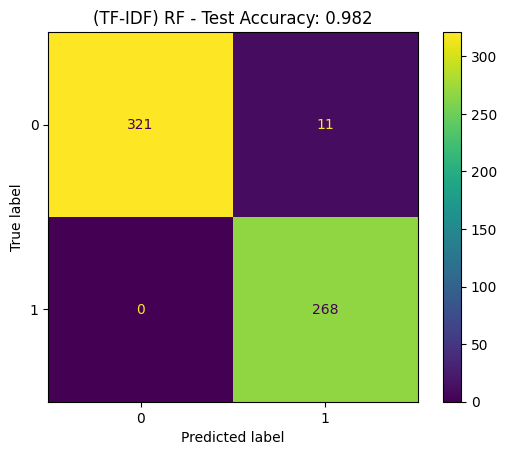

In [19]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
plt.title(f"(TF-IDF) RF - Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
plt.show()

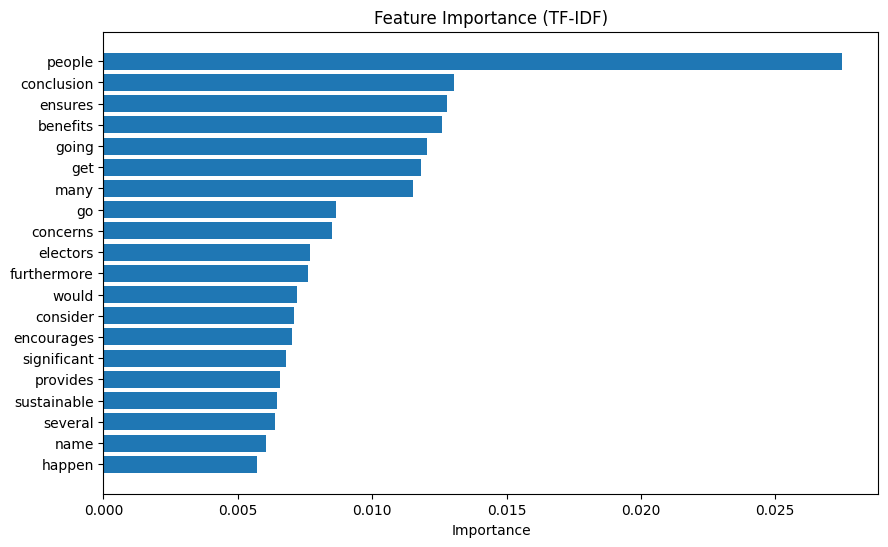

In [20]:
feature_importance = rf.feature_importances_
feature_names = tfidf.get_feature_names_out()
sorted_idx = feature_importance.argsort()[-20:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Importance")
plt.title("Feature Importance (TF-IDF)")
plt.show()

### 3.2 **Multinomial Naive Bayes (TF-IDF)**

In [21]:
mb = MultinomialNB()
y_cv = cross_val_predict(mb, X_train_tfidf, y_train, cv=5)

mb.fit(X_train_tfidf, y_train)
y_pred = mb.predict(X_test_tfidf)

print(f"(TF-IDF) Multinomial NB - Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(TF-IDF) Multinomial NB - Cross Validation Accuracy: 0.968


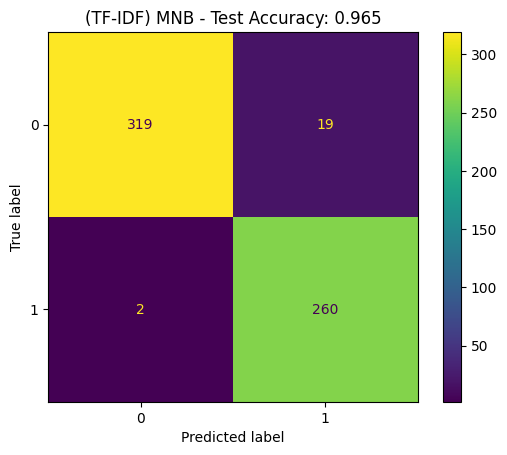

In [22]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
plt.title(f"(TF-IDF) MNB - Test Accuracy: {accuracy_score(y_test, y_pred)}")
plt.show()

### 3.3 **Multinomial Naive Bayes (Word2Vec)**

In [23]:
mb = MultinomialNB()
y_cv = cross_val_predict(mb, X_train_w2v, y_train, cv=5)

mb.fit(X_train_w2v, y_train)
y_pred = mb.predict(X_test_w2v)

print(f"(Word2Vec) Multinomial NB - Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(Word2Vec) Multinomial NB - Cross Validation Accuracy: 0.848


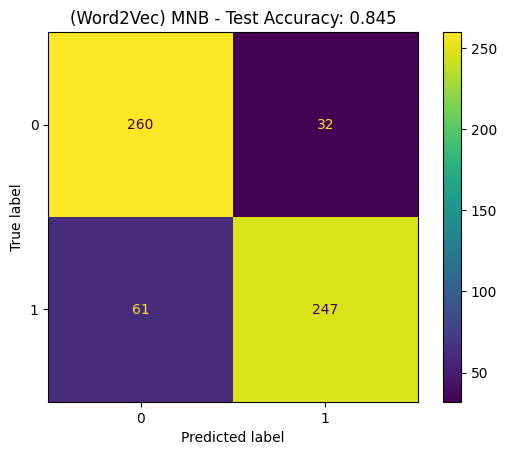

In [24]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
plt.title(f"(Word2Vec) MNB - Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
plt.show()

## 4. **<ins>Pretrained Model</ins>**

In [31]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
# Preprocess data for BERT
X_train_bert = tokenizer(X_train_clean.tolist(), padding=True, truncation=True, return_tensors="pt")
X_test_bert = tokenizer(X_test_clean.tolist(), padding=True, truncation=True, return_tensors="pt")

y_train_bert = torch.tensor(y_train.values)
y_test_bert = torch.tensor(y_test.values)

In [ ]:
# Train the BERT model
optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 3

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(**X_train_bert, labels=y_train_bert)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

In [ ]:
# Evaluate the BERT model
model.eval()
with torch.no_grad():
    val_outputs = model(**X_test_bert, labels=y_test_bert)
    val_loss = val_outputs.loss
    val_predictions = torch.argmax(val_outputs.logits, axis=1)
    val_accuracy = (val_predictions == y_test_bert).float().mean().item()

In [ ]:
print(f"BERT - Validation Accuracy: {val_accuracy:.3f}")

## 5. **<ins>Conclusion</ins>**

### 5.1 **Results of Validation set**

In [25]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
rf.fit(X_train_tfidf, y_train)

y_pred_train = rf.predict(X_train_tfidf)
y_pred_val = rf.predict(X_val_tfidf)
print(f"TF-IDF - Random Forest - Training Accuracy: {accuracy_score(y_train, y_pred_train):.3f}")
print(f"TF-IDF - Random Forest - Validation Accuracy: {accuracy_score(y_val, y_pred_val):.3f}")

TF-IDF - Random Forest - Training Accuracy: 1.000
TF-IDF - Random Forest - Validation Accuracy: 0.980


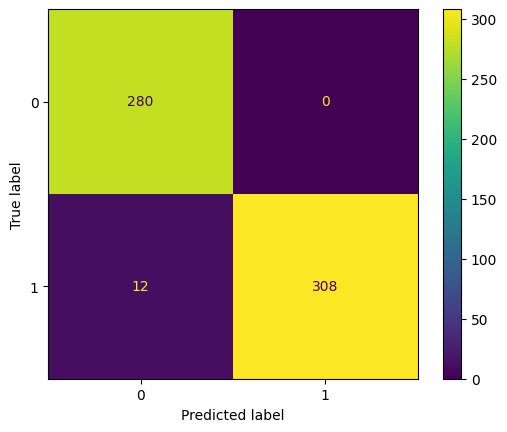

In [26]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val)
plt.show()

### 5.2 **Example with ChatGPT text**

In [27]:
chat_gpt = """
Recent studies suggest that regular exercise not only improves physical health but also has a positive impact
on mental well-being. Engaging in physical activities such as jogging, swimming, or yoga can reduce stress levels, 
boost mood, and increase overall happiness. Furthermore, exercise has been linked to better cognitive function and 
lower risk of developing certain chronic diseases. It's clear that making exercise a part of your routine can lead 
to a healthier and happier life.
"""

# Apply preprocessing to the chat_gpt text
chat_gpt_tok = tokenizer.tokenize(chat_gpt.lower())
chat_gpt_tok = [word for word in chat_gpt_tok if word not in stopwords.words('english')]
chat_gpt_tfidf = tfidf.transform([" ".join(chat_gpt_tok)])

# Predict the class of the chat_gpt text
y_pred_chat_gpt = rf.predict(chat_gpt_tfidf)
class_pred = "AI" if y_pred_chat_gpt[0] else "Human"
print("Predicted class: ", class_pred)

Predicted class:  AI
